In [1]:
#neutrino signal in SABRE South Veto detector, calculation based on https://arxiv.org/pdf/1712.06985.pdf and https://arxiv.org/pdf/1605.07803.pdf
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

from snvmodels.snv import SNv
from snvmodels.solarndists import SolarNDist
from detectors.nai import DAMA
from veldists import VelDist
from constants import *
from snvmodels.betheBloch_lab import plotBethe
import sympy
import scipy
from scipy.signal import gaussian, convolve

x = sympy.symbols('x')

In [2]:
Det = DAMA()
Model = SNv()

In [3]:
## Supernova neutrino flux
Ev = np.logspace(1,6,500) # Supernova neutrino energy, units of [keV]
Ev_eV = Ev*keV

In [4]:
def Flux_neutrino(Ev,epsilona,E_ave,gamma,L):
    Ev_MeV=Ev/MeV
    #lo = 3.086e+21 #1 kpc [cm]
    lo=1
    D=L*lo
    result = 3.5e13*1/(4*np.pi*D**2)*epsilona/E_ave*Ev_MeV**gamma/scipy.special.gamma(1+gamma)*((1+gamma)/E_ave)**(1+gamma)*np.exp(-(1+gamma)*Ev_MeV/E_ave)/MeV
    return result

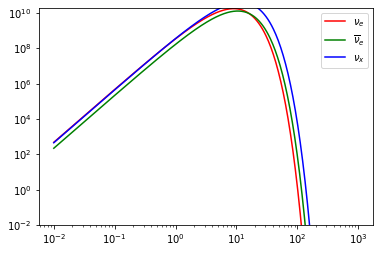

In [5]:
flux_electron_nu = Flux_neutrino(Ev_eV, 1,12,3,1) #[/cm2/keV]
plt.plot(Ev_eV/MeV, flux_electron_nu*MeV, label=r'$\nu_{e}$', color = 'r', linestyle='-')
flux_electron_nu = Flux_neutrino(Ev_eV, 1,14,3,1) #[/cm2/keV]
plt.plot(Ev_eV/MeV, flux_electron_nu*MeV, label=r'$\overline{\nu}_e$', color = 'g', linestyle='-')
flux_electron_nu = Flux_neutrino(Ev_eV, 4,16,3,1) #[/cm2/keV]
plt.plot(Ev_eV/MeV, flux_electron_nu*MeV, label=r'$\nu_x$', color = 'b', linestyle='-')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-1,3e2)
plt.ylim(1e-2, 2e10)
plt.legend()

In [6]:
def Sig(Ev,Eout,channel,source):
    """
    Differential cross section as a function of recoil energy Ed in [eV]
    mX: DM mass [eV]
    Ed: recoil energy [eV]
    Sig: cross section [cm2/eV]
    """
    ##inverse beta decay cross section (IBD) https://arxiv.org/pdf/astro-ph/0302055.pdf
    #Eout is for positron
    if channel == 'IBD':  
        pep=np.sqrt(Eout**2-me**2)
        cross_sec = 9.52e-44*(Eout*pep/MeV**2)
    elif channel == 'pES':
        cross_sec = 4.83e-42/MeV*(1+466*Eout/MeV/(Ev/MeV)**2)
    elif channel == 'eES':
        if source == 'supernova_e' or source == 'supernova_ea':
            epsilonN=-0.5-sin2thetaW
            epsilonP=-sin2thetaW
        else:
            epsilonN=0.5-sin2thetaW
            epsilonP=-sin2thetaW
        if source == 'supernova_e' or source == 'supernova_mu' or source == 'supernova_tau':
            cross_sec = 2*me*Gf**2/np.pi*(epsilonN**2+epsilonP**2*(1-Eout/Ev)**2-epsilonN*epsilonP*me*Eout/Ev**2)*0.3894*1e-45
        else:
            cross_sec = 2*me*Gf**2/np.pi*(epsilonP**2+epsilonN**2*(1-Eout/Ev)**2-epsilonN*epsilonP*me*Eout/Ev**2)*0.3894*1e-45
    return cross_sec

In [7]:
def dRdEd(Ev,Ed,E_ave,channel,source):
    """
    For this model, we just take coupling of n and p to be equal, and the only operator we care about is O1
    [mX] = [eV] DM mass
    [Ed] = [eV] DM recoil energy
    [sig] = [cm2/eV] cross section

    Output units: [cm^2]/[eV] 
    """
    # Intergration over neutrino spectrum
    Np=7e28 #per ton from https://arxiv.org/pdf/1712.06985.pdf
    NC=4.4e28
    Ne=Np+6*NC
    if channel == "IBD":
        Eout=Ed-me
        Ev=Eout+Delta_np
        if Ev > Delta_np+me:
            #integral = Np * Sig( Ev, Eout, channel) * Model.Flux_neutrino(Ev,source)
            integral = Np * Sig( Ev, Eout, channel,source) * Flux_neutrino(Ev, 1,12,3,1)
        else:
            integral = 0
    elif channel == "pES":
        def integrand(Ev,Ed,e_ave,channel):
            return Np * Sig( Ev, Ed, channel,source) * Flux_neutrino(Ev, 1,e_ave,3,1)
        Emin=np.sqrt(Ed*mproton/2)
        integral = integrate.quad(lambda Evl:integrand(Evl,Ed,E_ave,channel),Emin,max(Ev))[0] 
    elif channel == "eES":
        def integrand(Ev,Ed,e_ave,channel):
            return Ne * Sig( Ev, Ed, channel,source) * Flux_neutrino(Ev, 1,e_ave,3,1)
        Emin=Ed/2+np.sqrt(Ed*(Ed+2*me))/2
        integral = integrate.quad(lambda Evl:integrand(Evl,Ed,E_ave,channel),Emin,max(Ev))[0] 
    return integral

Text(0, 0.5, 'Counts [/MeV/ton]')

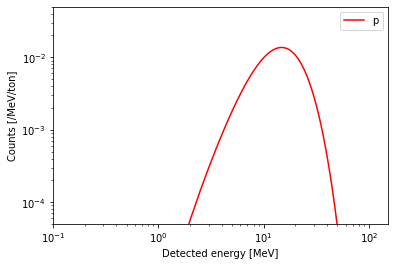

In [8]:
num=100
Ed = np.linspace(0,50,num)[1:]# Nuclear recoil energy, units of keV
Ed_eV = Ed*MeV # Nuclear recoil energy, units of keV
T=Det.Nuclei()
rate_supernova_IBD=np.array([dRdEd(Ev_eV,Edi,12,'IBD','supernova_e')*MeV for Edi in Ed_eV])
plt.plot(Ed,rate_supernova_IBD,label='p',color='r')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e-1,1.5e2)
plt.ylim(5e-5, 5e-2)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")

In [9]:
print("Channel IBD: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(rate_supernova_IBD,Ed)*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(rate_supernova_IBD,Ed)*10)

Channel IBD: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  4652.1212833593145
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  2.3260606416796574


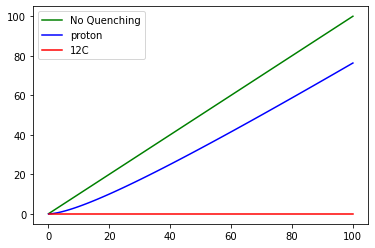

In [10]:
#define queching effect
def quenching(T,z,M):
    dx = 1e-4
    quenching=0
    while T > 0.01:
        yy = plotBethe(T,z,M)
        dE=yy*dx
        quenching += 1/(1+0.01*yy)*dE
        T = T-dE
    else:
        quenching += 1/(1+0.01*yy)*T
    return quenching
T = np.logspace(-1,2,100)

T_p = [quenching(i,1,938.27) for i in T]
T_C12 = [quenching(i,6,mp*12) for i in T]
plt.plot(T,T,'g',label=r'No Quenching')
plt.plot(T,T_p,'b',label=r'proton')
plt.plot(T,T_C12,'r',label=r'12C')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [11]:
print(quenching(10,1,938.27))

3.737886503033462


Text(0, 0.5, 'Counts [/MeV/ton]')

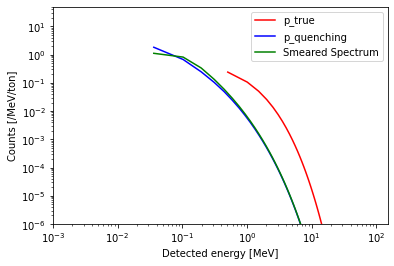

In [12]:
#Ed = np.logspace(np.log10(0.1),np.log10(10),500)
#true recoil energy spectrum
T=Det.Nuclei()
rate_supernova_pES=np.array([(dRdEd(Ev_eV,Edi,12,'pES','supernova_e')+dRdEd(Ev_eV,Edi,14,'pES','supernova_ea')+4*dRdEd(Ev_eV,Edi,16,'pES','supernova_x'))*MeV for Edi in Ed_eV])
plt.plot(Ed,rate_supernova_pES,label='p_true',color='r')


#queching effect
Ed_q=np.array([quenching(i,1,938.27) for i in Ed])
dEddEd_q = np.gradient(Ed)/np.gradient(Ed_q)
plt.plot(Ed_q,rate_supernova_pES*dEddEd_q,label='p_quenching',color='b')

#gaussian smearing
# Define the width and shape of the Gaussian function
width = 0.03*np.sqrt(Ed)*num/20
gaussian_function = gaussian(len(Ed), std=width)
# Normalize the Gaussian function
gaussian_function /= sum(gaussian_function)
# Convolve the spectrum with the Gaussian function
smeared_pES = convolve(rate_supernova_pES*dEddEd_q, gaussian_function, mode='same')
plt.plot(Ed_q, smeared_pES, label='Smeared Spectrum',color='g')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e-3,1.5e2)
plt.ylim(1e-6, 5e1)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")

In [13]:
print("Channel pES: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)

Channel pES: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  557.6340666464318
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  1.7201084097658779


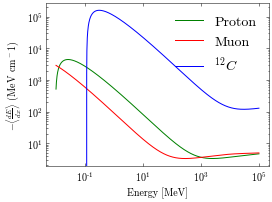

In [14]:
plt.style.use(['science','no-latex'])
plt.figure(figsize=(4,3))
ax = plt.axes()

ee = np.logspace(-2,5,1000)
#ee=(gamma(xx)-1)*M
#Proton
z = 1
M = 938.27
yy = [plotBethe(i,z,M) for i in ee]
plt.plot(ee,yy,'g',label=r'Proton')

#muon
z = 1
M = 106
yy = [plotBethe(i,z,M) for i in ee]
plt.plot(ee,yy,'r',label=r'Muon')

#Alpha
z = 6
M = 12*931.4941
yy = [plotBethe(i,z,M) for i in ee]
plt.plot(ee,yy,'b',label=r'$^{12}C$')

#fit.add_grid(ax)
plt.yscale('log')
plt.xscale('log')

plt.xticks()
plt.yticks()
#plt.xlabel(r'$\beta\gamma$')
plt.xlabel(r'Energy [MeV]')
plt.ylabel(r'$-\left<\frac{dE}{dx}\right>$ (MeV cm$^-1$)')
plt.legend(fontsize=14)
plt.show()

Text(0, 0.5, 'Counts [/MeV/ton]')

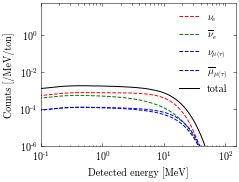

In [15]:
#Ed = np.logspace(np.log10(0.1),np.log10(10),500)
#true recoil energy spectrum
num=1000
Edd = np.linspace(0,50,num)[1:]# Nuclear recoil energy, units of keV
Edd_eV = Edd*MeV
T=Det.Nuclei()

rate_supernova_eES_e=np.array([(dRdEd(Ev_eV,Edi,12,'eES','supernova_e'))*MeV for Edi in Edd_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')

#gaussian smearing
# Define the width and shape of the Gaussian function
width = 0.03*np.sqrt(Edd)*num/50
gaussian_function = gaussian(len(Edd), std=width)
# Normalize the Gaussian function
gaussian_function /= sum(gaussian_function)
# Convolve the spectrum with the Gaussian function
smeared_spectrum_e = convolve(rate_supernova_eES_e, gaussian_function, mode='same')
plt.plot(Edd, smeared_spectrum_e, label=r'$\nu_{e}$',color='r', linestyle='--')

rate_supernova_eES_ea=np.array([(dRdEd(Ev_eV,Edi,16,'eES','supernova_ea'))*MeV for Edi in Edd_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
# Convolve the spectrum with the Gaussian function
smeared_spectrum_ea = convolve(rate_supernova_eES_ea, gaussian_function, mode='same')
plt.plot(Edd, smeared_spectrum_ea, label=r'$\overline{\nu}_{e}$',color='g', linestyle='--')

rate_supernova_eES_mu=np.array([(dRdEd(Ev_eV,Edi,16,'eES','supernova_mu'))*MeV for Edi in Edd_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
# Convolve the spectrum with the Gaussian function
smeared_spectrum_mu = convolve(rate_supernova_eES_mu, gaussian_function, mode='same')
plt.plot(Edd, smeared_spectrum_mu, label=r'$\nu_{\mu(\tau)}$',color='b', linestyle='--')

rate_supernova_eES_mua=np.array([(dRdEd(Ev_eV,Edi,16,'eES','supernova_mua'))*MeV for Edi in Edd_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
# Convolve the spectrum with the Gaussian function
smeared_spectrum_mua = convolve(rate_supernova_eES_mua, gaussian_function, mode='same')
plt.plot(Edd, smeared_spectrum_mua, label=r'$\overline{\mu}_{\mu(\tau)}$',color='b', linestyle='--')

smeared_eES = smeared_spectrum_e+smeared_spectrum_ea+2*smeared_spectrum_mu+2*smeared_spectrum_mua
plt.plot(Edd, smeared_eES, label=r'total',color='black')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e-1,1.5e2)
plt.ylim(1e-6, 5e1)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")

In [16]:
print("Channel eES: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_eES[Edd>0.2],Edd[Edd>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_eES[Edd>0.05],Edd[Edd>0.05])*10)

Channel eES: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  339.4893771476643
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  0.1717483200295147


Text(0, 0.5, 'Counts [/MeV/ton]')

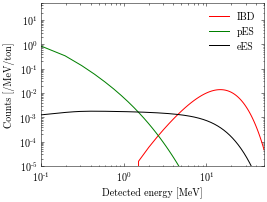

In [17]:
plt.figure(figsize=(4,3))
plt.plot(Ed,rate_supernova_IBD,label='IBD',color='r')
plt.plot(Ed_q, smeared_pES, label='pES',color='g')
plt.plot(Edd, smeared_eES, label=r'eES',color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e-1,5e1)
plt.ylim(1e-5, 5e1)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")